# Идея

$$F(t) = m \cdot x'' + 2 \cdot m \cdot \delta \cdot x' + w_0^2 \cdot m \cdot x $$

где F(t) — сила(пусть пока известная и константная, например $sin(\Omega t)$.

У такого маятника решение описано [тут](https://mipt.ru/education/chair/physics/S_I/method/Meh_col.pdf) в части 3.3.

Пусть мы знаем фазу и амплитуду реальной системы (формула 31 на стр. 25) и мы хотим настроить параметры $\delta$ и $m$ так чтобы они совпадали для нашей системы и симулятора.

Тогда контроллер принимает следующие вещи: ($\Omega$, $t$, $m$, $\delta$, $w_0$, $x$, $x'$), а выдаёт ($m$, $\delta$), которые бы минимизировали разницу фазы и амплитуды между реальной системой и симулятором.

In [1]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, glob, os
import random
import torch
from collections import deque

import gym
from gym import error, spaces, utils
from gym.utils import seeding

In [2]:
from ddpg_agent import Agent

### Env

In [3]:
# откуда взять f_0 в ф. 29 ?
# почему параметры можели меняются?


class PendulumEnv(gym.Env):
    def __init__(self, big_b=1, big_omega=1, theta=0,
                 m=1, k=0.1, beta=0.02, big_f_0=1,
                 n_steps=100, t_min=0, t_max=10):
        """
        Args:
            big_b (float): амплитуда.
            big_omega (float): частота.
            theta (float): фаза.
            m (float): масса грузика.
            k (float): жесткость пружины. 
            beta (float): коэф сопротивления среды.
            big_f_0 (float): ????.
            n_steps (int): количество шагов до завершения среды.
            t_min, t_max (float): min and max time.
        """
        
        # init
        self.initial_params = locals().copy()
        del self.initial_params['self']
        
        # system params
        self.big_b = big_b
        self.big_omega = big_omega
        self.theta = theta
        self.m = m
        self.k = k
        self.beta = beta
        self.big_f_0 = big_f_0
        
        self.delta = self.beta / (2 * self.m)
        self.omega_0 = self.k / self.m
        
        # RL params
        self.n_steps = n_steps
        self.t_min, self.t_max = t_min, t_max
        self._randomize_t()
        self.i = 0
        self.state_space = self._dc_input().shape[0]
        
    def _system(self, t=None):
        """Returns the real system position (f.31)."""
        if t is None:
            t = self.t
        return self.big_b * np.cos(self.big_omega * t - self.theta)
    
    def _x(self, t):
        return self._system(t)
    
    def _x_first_deriv(self, t):
        return - self.big_b * self.big_omega * np.sin(self.big_omega * t - self.theta)
    
    def _x_second_deriv(self, t):
        return - self.big_b * (self.big_omega**2) * np.cos(self.big_omega * t - self.theta)
    
    def _system_model(self, m, delta, big_omega, t=None):
        """Returns the model position."""
        if t is None:
            t = self.t
        big_b = self._big_b_model(m, delta, big_omega)
        theta = self._theta_model(m, delta, big_omega)
        return big_b * np.cos(big_omega * t - theta)
    
    def _dc_input(self, t=None):
        if t is None:
            t = self.t
        return np.array([
            self.big_omega,
            t,
            self.m,
            self.delta,
            self.omega_0,
            self._x(t),
            self._x_first_deriv(t),
        ])
    
    def _randomize_t(self):
#         self.t = np.random.uniform(self.t_min, self.t_max)
        t_space = np.arange(10)
        self.t = np.random.choice(t_space)
        
    def _big_b_model(self, m, delta, big_omega):
        omega_0_sqr = self.k / m
        f_0 = self.big_f_0 / m
        
        res = (omega_0_sqr**2 - big_omega**2)**2
        res += 4 * delta**2 * big_omega**2
        res = f_0 / res**0.5
        return res
    
    def _theta_model(self, m, delta, big_omega):
        omega_0_sqr = self.k / m
        
        res = 2 * delta * big_omega
        res /= omega_0_sqr - big_omega**2
        return res

    def step(self, action):

        # state
        self.i += 1

        # reward
        m_, delta_, big_omega_ = tuple(action)
        big_b_ = self._big_b_model(m_, delta_, big_omega_)
        theta_ = self._theta_model(m_, delta_, big_omega_)
        
        reward = 0
        reward -= (self.big_b - big_b_) ** 2
        reward -= (self.theta - theta_) ** 2

        # done
        done = self.i == self.n_steps
        
        # info
        info = {"x_model": big_b_ * np.cos(big_omega_ * self.t - theta_)}
        
        # obs
        self._randomize_t()
        obs = self._dc_input()

        return obs, reward, done, info
    
    def reset(self):
        self.__init__(**self.initial_params)
        self._randomize_t()
        return self._dc_input()
    
    def get_seq_x(self, t_space):
        return [self._x(t) for t in t_space]
    
    def get_seq_states(self, t_space):
        return np.array([self._dc_input(t) for t in t_space])

    @property
    def observation_space(self):
        return spaces.Box(low=-100, high=100, shape=(self.state_space,), dtype=np.float32)

    @property
    def action_space(self):
        # m, delta, big_omega
        return spaces.Box(low=-100, high=100, shape=(3,), dtype=np.float32)


In [4]:
env = PendulumEnv()
o, r, d, _ = env.step([env.m, env.delta, env.big_omega])
assert np.isclose(r, 0, atol=1e-3)
o, r, d, _ = env.step([env.m, env.delta, env.big_omega + 1])
assert not np.isclose(r, 0, atol=1e-3)

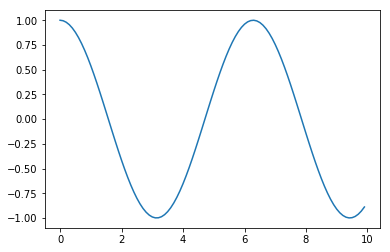

In [5]:
env.reset()
t_space = np.arange(100) / 10
plt.plot(t_space, env.get_seq_x(t_space))
plt.show()

# DDPG

In [6]:
# TODO: fix actions

def ddpg(n_episodes=200, max_t=300, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            agent.reset()
            env.reset()
            t_space = np.arange(10)#, step=0.1)
            expected_points = env.get_seq_x(t_space)
            states = env.get_seq_states(t_space)
            # noise -- falses[]
            actions = np.array([agent.act(s, add_noise=False) for s in states])
#             print(actions[0])
            points = [env._system_model(a[0], a[1], a[2], t) for a, t in zip(actions, t_space)]
            plt.plot(t_space, expected_points)
            plt.plot(t_space, points)
            plt.show()
            
    return scores

In [7]:
env = PendulumEnv()
agent = Agent(state_size=7, action_size=3, random_seed=2)

/home/dev/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 5	Average Score: -13757.00


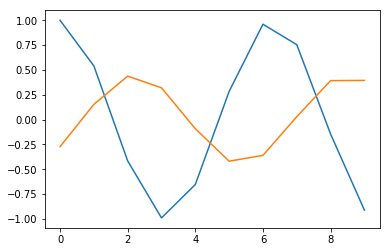

Episode 10	Average Score: -73.3457


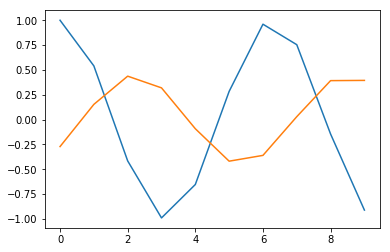

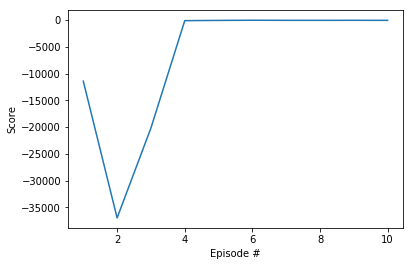

In [8]:
scores = ddpg(n_episodes=10, max_t=300, print_every=5)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()